In [14]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb

df = pd.read_csv('artificial_1.csv' ,parse_dates=["date"])

#df.to_string()
print(df.head())


        date      value  temperature
0 2018-01-01  72.624345          6.0
1 2018-01-02  65.388244         10.0
2 2018-01-03  65.471828         11.0
3 2018-01-04  64.927031          8.0
4 2018-01-05  66.865408         10.0


In [22]:
def evaluatereg(actual,prediction):
    
    return  (mse(actual, prediction), rmse(actual, prediction), r2_score(actual,prediction),np.mean(np.abs((prediction - actual) /np.abs(actual))) * 100) 

In [79]:
from pandas import concat
temps = DataFrame(df.value)
len(temps)
width = 3
window4 = temps.shift(2).expanding()
shifted = temps.shift(width - 1)
window = shifted.rolling(window=width)
dataframe = concat([window.min(), window.mean(), window.max()], axis=1)
dataframe.columns = [ 'min_value', 'mean_value', 'max_value']
temps = DataFrame(df.value)


dates = pd.to_datetime(df.date)
test_df = df.copy()
test_df["year"] = dates.dt.year
test_df["month"] = dates.dt.month
test_df["day"] = dates.dt.day


dataframe3= pd.concat([test_df["year"], test_df["month"],test_df["day"], dataframe.min_value, dataframe.mean_value, dataframe.max_value, window4.min(), window4.mean(), window4.max(), temps.shift(1), temps.shift(2), temps.shift(3),temps.shift(7),temps.shift(8)],axis=1)

dataframe3.columns = [ 'year', 'month', 'day','min_rolling','mean_rolling',  'max_rolling','min_expanding', 'mean_expanding', 'max_expanding','t-1','t-2','t-3','t-7','t-8']

dataframeee=[df,dataframe3]

dataframe2= pd.concat(dataframeee, "columns").dropna()

#seasons
seasonsdataframe=DataFrame()
l=[]
for i in test_df.month.values:
    if i== 6 or 7 or 8:
        l.append('2')
    if i == 3 or 4 or 5:
        l.append('1')
    if i== 9 or 10 or 11:
        l.append('3')
    if i== 12 or 1 or 2:
        l.append('4')
seasonsdataframe = pd.DataFrame(l)
seasonsdataframe.columns= ['seasons']
dataframe2["seasons"]=seasonsdataframe.seasons
dataframe2['sin_month'] = np.sin((dataframe2.month-1)*(2.*np.pi/12))
dataframe2['cos_month'] = np.cos((dataframe2.month-1)*(2.*np.pi/12))
dataf = df.value.copy()
shifted6 = dataf.shift(6)
window7 = shifted6.rolling(7).mean()
shifted7 = dataf.shift(7)
window8= shifted7.rolling(8).mean()
shifted4 = dataf.shift(4)
window5 = shifted4.rolling(5).mean()
shifted3 = dataf.shift(3)
window4= shifted3.rolling(4).mean()
shifted1 = dataf.shift(1)
window2= shifted1.rolling(2).mean()
#shifted8 = dataf.shift(8)
#window9= shifted7.rolling(9).mean()
window7.dropna()
window8.dropna()
window4.dropna()
window5.dropna()
window2.dropna()
#window9.dropna()

dataframe2["rolling7"] = window7
dataframe2["rolling8"] =window8
dataframe2["rolling4"] =window4
dataframe2["rolling5"] =window5
dataframe2["rolling2"] =window2
#dataframe2["rolling9"] =window9
dataframe2 = dataframe2.dropna()
dataframe2.head()

,date,value,temperature,year,month,day,min_rolling,mean_rolling,max_rolling,min_expanding,...,t-7,t-8,seasons,sin_month,cos_month,rolling7,rolling8,rolling4,rolling5,rolling2
14,2018-01-15,72.133769,2.0,2018,1,15,42.939859,44.693183,46.462108,39.238793,...,39.238793,67.744812,3,0.0,1.0,59.037910,63.244865,44.867909,48.703076,44.646764
15,2018-01-16,64.900109,2.0,2018,1,16,42.939859,44.077796,44.677583,39.238793,...,45.319039,39.238793,4,0.0,1.0,56.077739,59.831702,44.707545,43.742086,58.374858
16,2018-01-17,65.827572,7.0,2018,1,17,44.615946,53.809099,72.133769,39.238793,...,44.750630,45.319039,2,0.0,1.0,53.439893,57.252000,44.673874,44.829844,68.516939
17,2018-01-18,65.122142,8.0,2018,1,18,44.615946,60.549941,72.133769,39.238793,...,46.462108,44.750630,1,0.0,1.0,50.021957,54.875785,51.091789,44.689225,65.363840
18,2018-01-19,66.042214,4.0,2018,1,19,64.900109,67.620483,72.133769,39.238793,...,42.939859,46.462108,3,0.0,1.0,47.304689,52.127389,56.581852,50.165853,65.474857


In [85]:
dataframe2copy=dataframe2.copy()
train=dataframe2copy[:-60]
test=dataframe2copy[-60:]
x_train=train.drop(labels=["value","date"],axis=1)
y_train=train["value"]
x_test=test.drop(labels=["value","date"],axis=1)
y_test=test["value"]
x_train.tail()

,temperature,year,month,day,min_rolling,mean_rolling,max_rolling,min_expanding,mean_expanding,max_expanding,...,t-7,t-8,seasons,sin_month,cos_month,rolling7,rolling8,rolling4,rolling5,rolling2
665,21.0,2019,10,28,53.209004,57.924332,65.020110,27.762913,49.730839,72.624345,...,60.843006,35.040371,1,-1.000000,-1.836970e-16,46.039223,40.636154,57.327806,53.930144,65.856342
666,20.0,2019,10,29,55.543882,62.418856,66.692574,27.762913,49.756345,72.624345,...,64.664797,60.843006,3,-1.000000,-1.836970e-16,48.851642,44.856254,57.416634,58.030846,48.106951
667,19.0,2019,10,30,29.521328,53.744671,66.692574,27.762913,49.725962,72.624345,...,55.893540,64.664797,4,-1.000000,-1.836970e-16,50.064766,47.271013,60.116393,58.866267,32.096138
668,19.0,2019,10,31,29.521328,43.628283,66.692574,27.762913,49.703391,72.624345,...,53.209004,55.893540,2,-1.000000,-1.836970e-16,51.609082,49.396312,54.194474,59.271822,35.509027
669,13.0,2019,11,1,29.521328,33.513127,36.347105,27.762913,49.683396,72.624345,...,55.543882,53.209004,1,-0.866025,5.000000e-01,55.744959,50.749656,48.976240,53.997380,35.149019


In [86]:
dataframe2.date.iloc[-60:]

670   2019-11-02
671   2019-11-03
672   2019-11-04
673   2019-11-05
674   2019-11-06
675   2019-11-07
676   2019-11-08
677   2019-11-09
678   2019-11-10
679   2019-11-11
680   2019-11-12
681   2019-11-13
682   2019-11-14
683   2019-11-15
684   2019-11-16
685   2019-11-17
686   2019-11-18
687   2019-11-19
688   2019-11-20
689   2019-11-21
690   2019-11-22
691   2019-11-23
692   2019-11-24
693   2019-11-25
694   2019-11-26
695   2019-11-27
696   2019-11-28
697   2019-11-29
698   2019-11-30
699   2019-12-01
700   2019-12-02
701   2019-12-03
702   2019-12-04
703   2019-12-05
704   2019-12-06
705   2019-12-07
706   2019-12-08
707   2019-12-09
708   2019-12-10
709   2019-12-11
710   2019-12-12
711   2019-12-13
712   2019-12-14
713   2019-12-15
714   2019-12-16
715   2019-12-17
716   2019-12-18
717   2019-12-19
718   2019-12-20
719   2019-12-21
720   2019-12-22
721   2019-12-23
722   2019-12-24
723   2019-12-25
724   2019-12-26
725   2019-12-27
726   2019-12-28
727   2019-12-29
728   2019-12-

# Bagging Meta Estimator

In [87]:

model=BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model.fit(x_train, y_train)
pred_bagging=model.predict(x_test)
pred_bagging_train=model.predict(x_train)

print(model.score(x_test,y_test))
print(model.score(x_train,y_train))
print('Test scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' % evaluatereg(y_test,pred_bagging))
print('Train scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' % evaluatereg(y_train,pred_bagging_train))

0.9926971317868813
0.9986685390126636
Test scores, 
 MSE: 1.078, RMSE: 1.038, R2 score: 0.993, MAPE: 1.590
Train scores, 
 MSE: 0.225, RMSE: 0.475, R2 score: 0.999, MAPE: 0.749


In [88]:
len(pred_bagging)

60

Text(0, 0.5, 'Value')

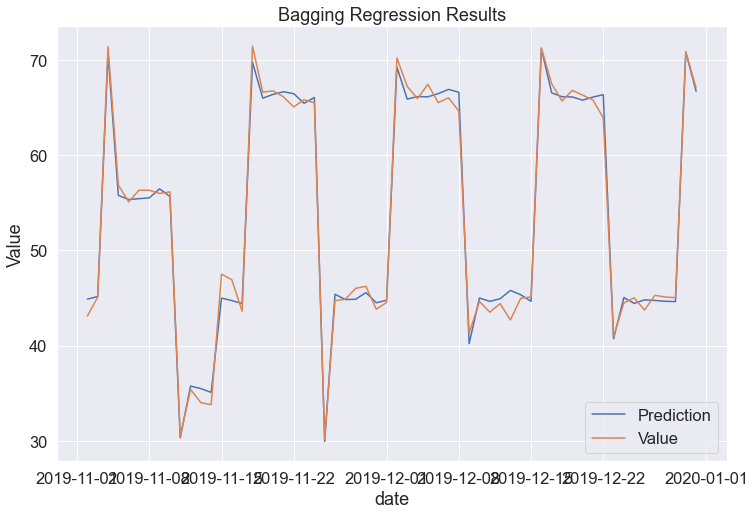

In [89]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(dataframe2.date.iloc[-60:], pred_bagging)
plt.plot(dataframe2.date.iloc[-60:],y_test)
plt.legend(['Prediction','Value'])
plt.title('Bagging Regression Results')
plt.xlabel('date')
plt.ylabel('Value')

# AdaBoost

In [90]:
modelada = AdaBoostRegressor()
modelada.fit(x_train, y_train)
pred_adaboost=modelada.predict(x_test)
pred_adaboost_train=modelada.predict(x_train)

print('Test scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_test,pred_adaboost))
print('Train scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_train,pred_adaboost_train))


Test scores, 
 MSE: 0.950, RMSE: 0.974, R2 score: 0.994, MAPE: 1.453
Train scores, 
 MSE: 0.988, RMSE: 0.994, R2 score: 0.994, MAPE: 1.753


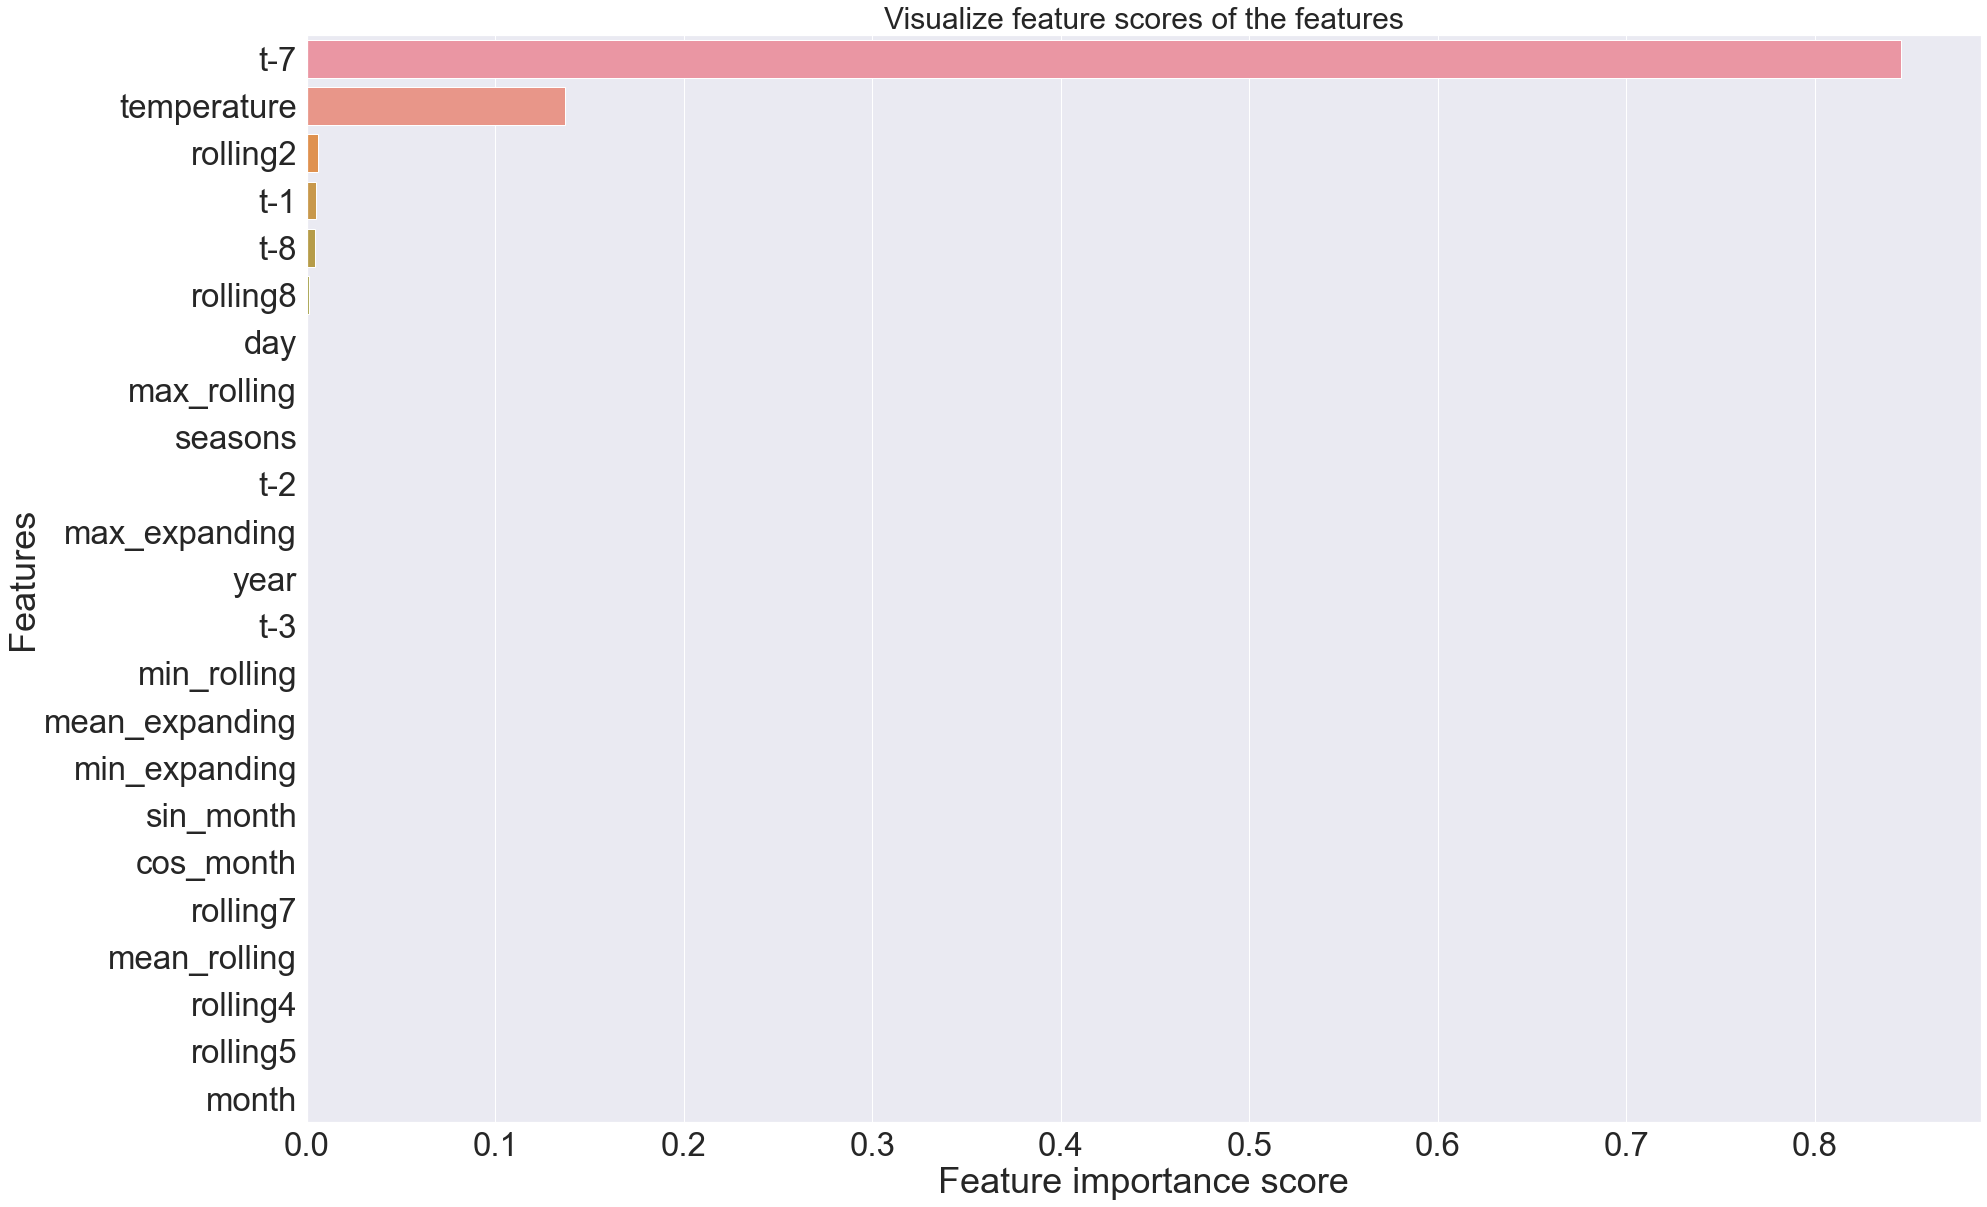

In [116]:
feature_scores = pd.Series(modelada.feature_importances_, index=x_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale = 2.5)
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)

ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")


plt.show()

In [92]:
parameters=[{'n_estimators': [1,5,10,100,200],'learning_rate':[0.1,0.2,0.4,0.8],  'random_state':[0,1]}]
grid_search = GridSearchCV(modelada, parameters, cv=5, scoring='neg_mean_squared_error',return_train_score=True) 
grid_search.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.4, 0.8],
                          'n_estimators': [1, 5, 10, 100, 200],
                          'random_state': [0, 1]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [93]:
grid_search.best_params_


{'learning_rate': 0.4, 'n_estimators': 5, 'random_state': 1}

In [110]:
modelada_tuned = AdaBoostRegressor(learning_rate= 0.4, n_estimators= 5, random_state= 1)
modelada_tuned.fit(x_train, y_train)
pred_adaboost_tuned =modelada_tuned .predict(x_test)
pred_adaboost_train_tuned =modelada_tuned .predict(x_train)

print('After gridsearch test score\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(y_test,pred_adaboost_tuned ))
print('Before gridsearch test score\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(y_test,pred_adaboost))

print('\n\nAfter gridsearch training score\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(y_train,pred_adaboost_train_tuned ))

print('before gridsearch training score\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(y_train,pred_adaboost_train))

After gridsearch test score
 MSE: 0.921, RMSE: 0.960, R2 score: 0.994, MAPE: 1.450
Before gridsearch test score
 MSE: 0.950, RMSE: 0.974, R2 score: 0.994, MAPE: 1.453


After gridsearch training score
 MSE: 0.972, RMSE: 0.986, R2 score: 0.994, MAPE: 1.719
before gridsearch training score
 MSE: 0.988, RMSE: 0.994, R2 score: 0.994, MAPE: 1.753


Text(0, 0.5, 'Value')

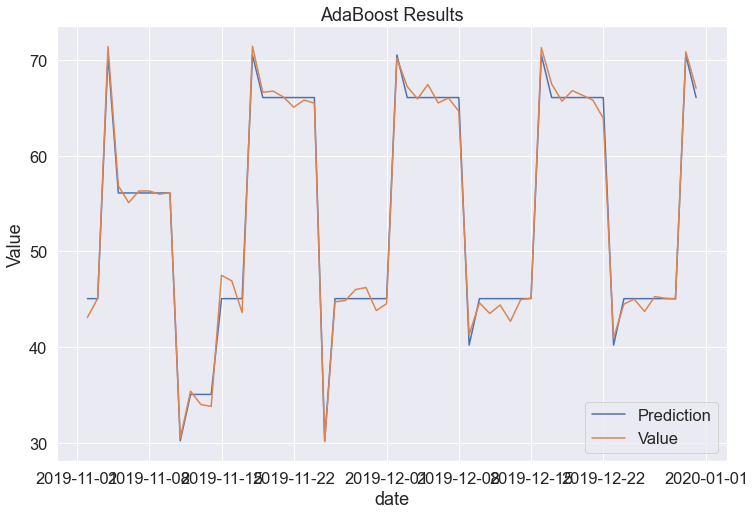

In [98]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(dataframe2.date.iloc[-60:],pred_adaboost_tuned)
plt.plot(dataframe2.date.iloc[-60:],y_test)
plt.legend(['Prediction','Value'])

plt.title('AdaBoost Results')
plt.xlabel('date')
plt.ylabel('Value')


# GBM

In [99]:
GBMmodel= GradientBoostingRegressor()
GBMmodel.fit(x_train, y_train)
GBM_pred = GBMmodel.predict(x_test)
GBM_pred_train = GBMmodel.predict(x_train)

print('Test scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_test,GBM_pred))

print('Train scores,','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_train,GBM_pred_train))

Test scores, 
 MSE: 1.126, RMSE: 1.061, R2 score: 0.992, MAPE: 1.562
Train scores, 
 MSE: 0.533, RMSE: 0.730, R2 score: 0.997, MAPE: 1.270


Text(0, 0.5, 'Value')

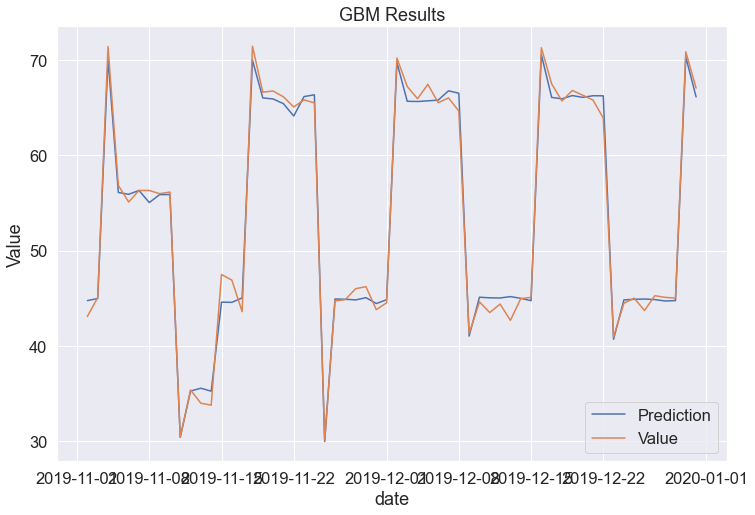

In [100]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(dataframe2.date.iloc[-60:],GBM_pred)
plt.plot(dataframe2.date.iloc[-60:],y_test)
plt.legend(['Prediction','Value'])

plt.title('GBM Results')
plt.xlabel('date')
plt.ylabel('Value')

In [102]:
param =[{'learning_rate':[0.01,0.1,0.2,0.4,0.8], 'n_estimators': [1,5,10,100,200,500],
         'random_state':[0,1,2,3],
         'max_features':[2, 4, 6, 8],
        'max_depth':[3,6,9,12],
        }]
grid_search_GBM = GridSearchCV(GBMmodel, parameters, cv=5, scoring='neg_mean_squared_error',return_train_score=True) 
grid_search_GBM.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.4, 0.8],
                          'n_estimators': [1, 5, 10, 100, 200],
                          'random_state': [0, 1]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [103]:
grid_search.best_params_

{'learning_rate': 0.4, 'n_estimators': 5, 'random_state': 1}

In [108]:
GBMmodel_new = GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 5, random_state= 1)
GBMmodel_new.fit(x_train, y_train)
pred_GBM_tuned =GBMmodel_new.predict(x_test)
pred_GBM_train_tuned =GBMmodel_new.predict(x_train)

print('After gridsearch test score','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_test,pred_GBM_tuned ))
print('Before gridsearch test score','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_test,GBM_pred))
print('\n\nAfter gridsearch training score','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_train,pred_GBM_train_tuned ))
print('Before gridsearch training score','\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f' %evaluatereg(y_train,GBM_pred_train))

After gridsearch test score 
 MSE: 2.024, RMSE: 1.423, R2 score: 0.986, MAPE: 2.352
Before gridsearch test score 
 MSE: 1.126, RMSE: 1.061, R2 score: 0.992, MAPE: 1.562


After gridsearch training score 
 MSE: 1.934, RMSE: 1.391, R2 score: 0.989, MAPE: 2.499
Before gridsearch training score 
 MSE: 0.533, RMSE: 0.730, R2 score: 0.997, MAPE: 1.270


Text(0, 0.5, 'Value')

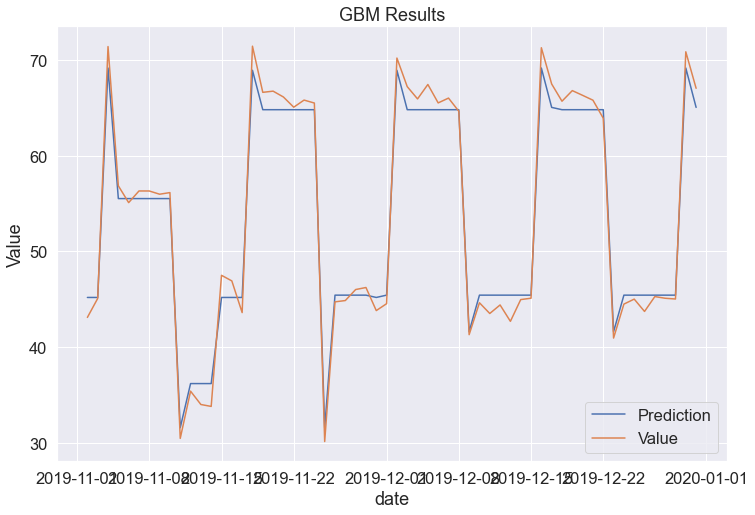

In [112]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(dataframe2.date.iloc[-60:],pred_GBM_tuned)
plt.plot(dataframe2.date.iloc[-60:],y_test)
plt.legend(['Prediction','Value'])

plt.title('GBM Results')
plt.xlabel('date')
plt.ylabel('Value')

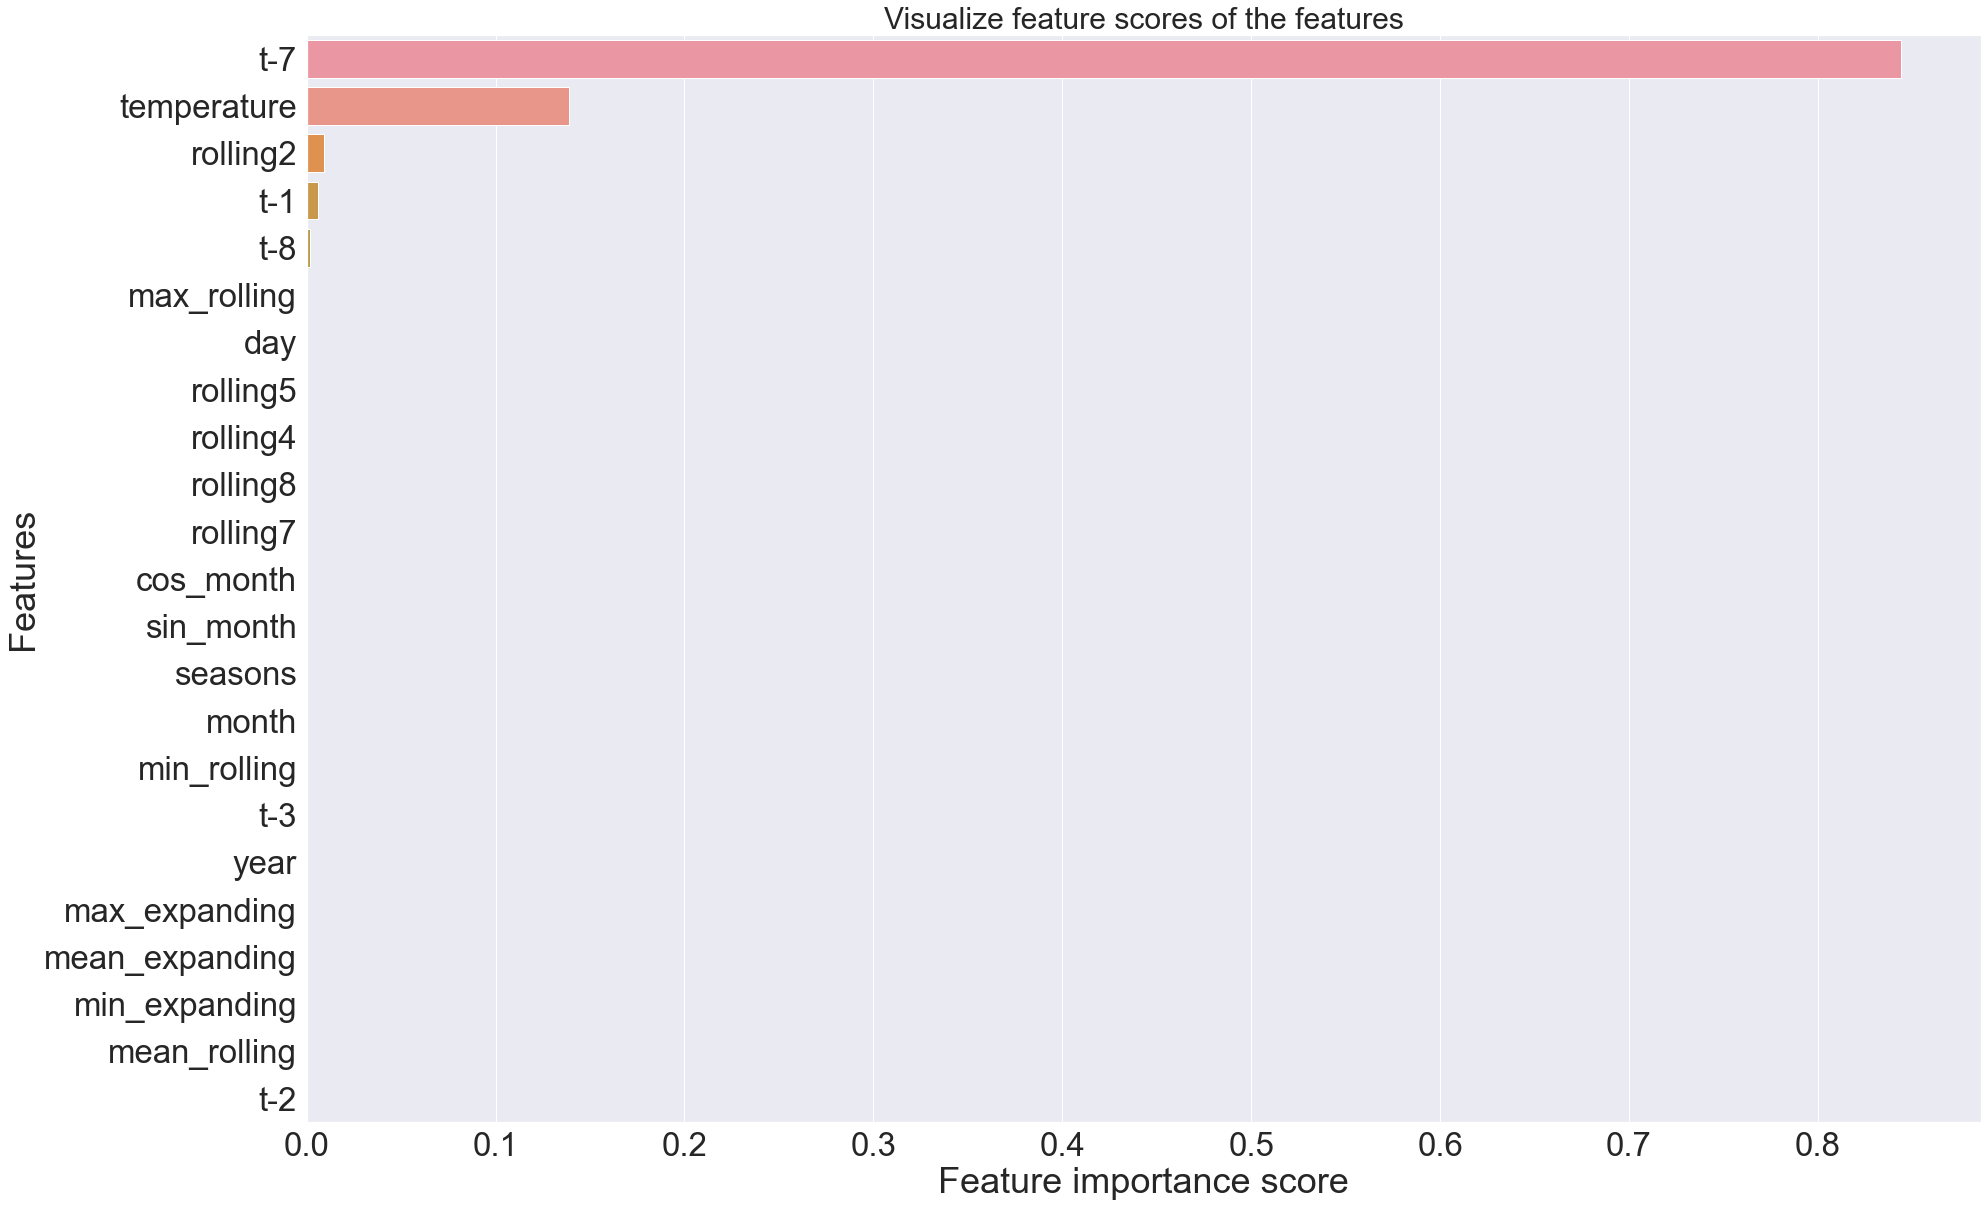

In [114]:
feature_scores = pd.Series(GBMmodel_new.feature_importances_, index=x_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale = 2.5)
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)

ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
sns.set(font_scale = 3)

plt.show()

In [125]:

new=pd.concat([dataframe2.value, dataframe2["t-7"], dataframe2.temperature,dataframe2["t-8"],dataframe2["t-1"]],axis=1)
new.labels=['value','t-7','temperature','t-8','t-1']
new_train=new.iloc[:-60]
new_test=new.iloc[-60:]
train_y=new_train.value
train_x=new_train.drop(columns="value")
test_y=new_test.value
test_x=new_test.drop(columns="value")
train_x

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,t-7,temperature,t-8,t-1
14,39.238793,2.0,67.744812,44.615946
15,45.319039,2.0,39.238793,72.133769
16,44.750630,7.0,45.319039,64.900109
17,46.462108,8.0,44.750630,65.827572
18,42.939859,4.0,46.462108,65.122142
...,...,...,...,...
665,60.843006,21.0,35.040371,66.692574
666,64.664797,20.0,60.843006,29.521328
667,55.893540,19.0,64.664797,34.670948
668,53.209004,19.0,55.893540,36.347105


In [128]:
GBMmodel_last= GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 5, random_state= 1)
GBMmodel_last.fit(train_x, train_y)
GBM_pred_last = GBMmodel_last.predict(test_x)
GBM_pred_train_last = GBMmodel_last.predict(train_x)

print('Test Scores,\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(test_y,GBM_pred_last))


print('Train Scores,\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%evaluatereg(train_y,GBM_pred_train_last))

Test Scores,
 MSE: 2.107, RMSE: 1.452, R2 score: 0.986, MAPE: 2.358
Train Scores,
 MSE: 1.966, RMSE: 1.402, R2 score: 0.988, MAPE: 2.514


In [68]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# XGBoost

In [134]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [130]:
import xgboost as xgb
XGBmodel=xgb.XGBRegressor()
XGBmodel.fit(x_train.astype(float), y_train)
XGBpred = XGBmodel.predict(x_test.astype(float))
XGBpred_train = XGBmodel.predict(x_train.astype(float))

XGBmodel.score(x_test.astype(float),y_test)
evaluatereg('Test Scores,\n','MSE: %.3f, RMSE: %.3f, R2 score: %.3f, MAPE: %.3f'%y_test,XGBpred)

(1.6204240372666057,
 1.2729587728071188,
 0.9890241989287655,
 1.9008670045491116)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

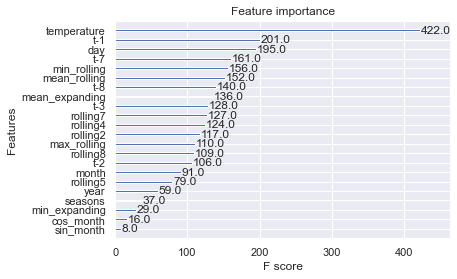

In [144]:

sns.set(font_scale = 1)
xgb.plot_importance(XGBmodel)


In [152]:
parameters=[{'colsample_bytree': [ 0.5, 0.7],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [100,200,400],
    'subsample': [0.2,0.5],
    'max_depth': [2, 3]}]
grid = GridSearchCV(estimator=XGBmodel, param_grid=parameters, scoring='neg_mean_squared_error',
                    cv=3, verbose=1)
grid.fit(x_train.astype(float), y_train.astype(float))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat...
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0,
     

In [153]:
 grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 400,
 'subsample': 0.5}

In [154]:
XGBmodel_tuned=xgb.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.01,
 max_depth= 3,
 n_estimators= 400,
 subsample= 0.5)
XGBmodel_tuned.fit(x_train.drop(columns="seasons"), y_train)
XGBpred_tuned = XGBmodel_tuned.predict(x_test.drop(columns="seasons"))
XGBpred_tuned_train = XGBmodel_tuned.predict(x_train.drop(columns="seasons"))

XGBmodel_tuned.score(x_test.drop(columns="seasons"),y_test)
print('Test score after grid search:',evaluatereg(y_test,XGBpred_tuned))
print('Test score before grid search:',evaluatereg(y_test,XGBpred))
print('Train score after grid search:',evaluatereg(y_train,XGBpred_tuned_train))
print('Train score before grid search:',evaluatereg(y_train,XGBpred_train))


Test score after grid search: (3.823322193511973, 1.9553317349012604, 0.9741030601483733, 3.0219917950312665)
Test score before grid search: (1.6204240372666057, 1.2729587728071188, 0.9890241989287655, 1.9008670045491116)
Train score after grid search: (2.7624963166036163, 1.6620759057887868, 0.9836852903555714, 2.588593269570447)
Train score before grid search: (0.002252451446420131, 0.04745999838200725, 0.9999866975057611, 0.07342368242963394)


In [155]:
xgb_train=pd.concat([x_train["temperature"],x_train["t-1"],x_train["t-7"],x_train["day"],x_train["t-2"],x_train["t-8"],x_train["mean_rolling"]],axis=1)
xgb_train.labels=['temperature','t-1','t-7','day','t-2', 't-8','mean_rolling']
xgb_test=pd.concat([x_test["temperature"],x_test["t-1"],x_test["t-7"],x_test["day"],x_test["t-2"],x_test["t-8"],x_test["mean_rolling"]],axis=1)
xgb_test.labels=['temperature','t-1','t-7','day','t-2', 't-8','mean_rolling']


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [157]:
XGBmodel_tuned=xgb.XGBRegressor(colsample_bytree= 0.9,
 learning_rate= 0.01,
 max_depth= 2,
 n_estimators= 1200,
 subsample= 0.8)
XGBmodel_tuned.fit(xgb_train, y_train)
XGBpred_tuned = XGBmodel_tuned.predict(xgb_test)
XGBpred_tuned_train = XGBmodel_tuned.predict(xgb_train)

XGBmodel_tuned.score(xgb_test,y_test)
print('Test score after tune:',evaluatereg(y_test,XGBpred_tuned))
print('Test score before tune:',evaluatereg(y_test,XGBpred))
print('Train score after tune:',evaluatereg(y_train,XGBpred_tuned_train))
print('Train score before tune:',evaluatereg(y_train,XGBpred_train))


Test score after tune: (1.4058849320378777, 1.1857001864037457, 0.9904773608708478, 1.6650906068943694)
Test score before tune: (1.6204240372666057, 1.2729587728071188, 0.9890241989287655, 1.9008670045491116)
Train score after tune: (0.8825917659078845, 0.9394635521976807, 0.9947876026806602, 1.6183602257955656)
Train score before tune: (0.002252451446420131, 0.04745999838200725, 0.9999866975057611, 0.07342368242963394)


Text(0, 0.5, 'Value')

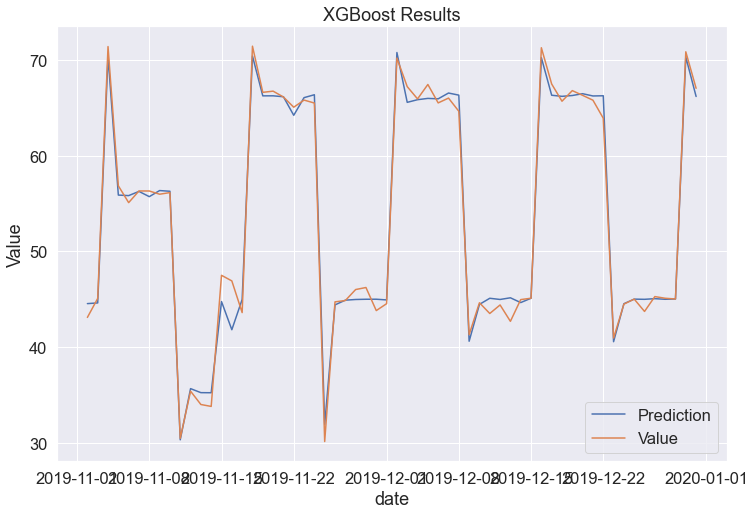

In [158]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(dataframe2.date.iloc[-60:],XGBpred_tuned)
plt.plot(dataframe2.date.iloc[-60:],y_test)
plt.legend(['Prediction','Value'])

plt.title('XGBoost Results')
plt.xlabel('date')
plt.ylabel('Value')

# LightGBM

In [171]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [168]:
x_train = x_train.astype(float)
x_test = x_test.astype(float)


In [164]:

LGBmodel = lgb.LGBMRegressor(boosting_type='gbdt')
clf = LGBmodel.fit(x_train, y_train)
LGBpred = LGBmodel.predict(x_test)
evaluatereg(y_test, LGBpred)
LGBmodel.score(x_test,y_test)

0.9901758926190503

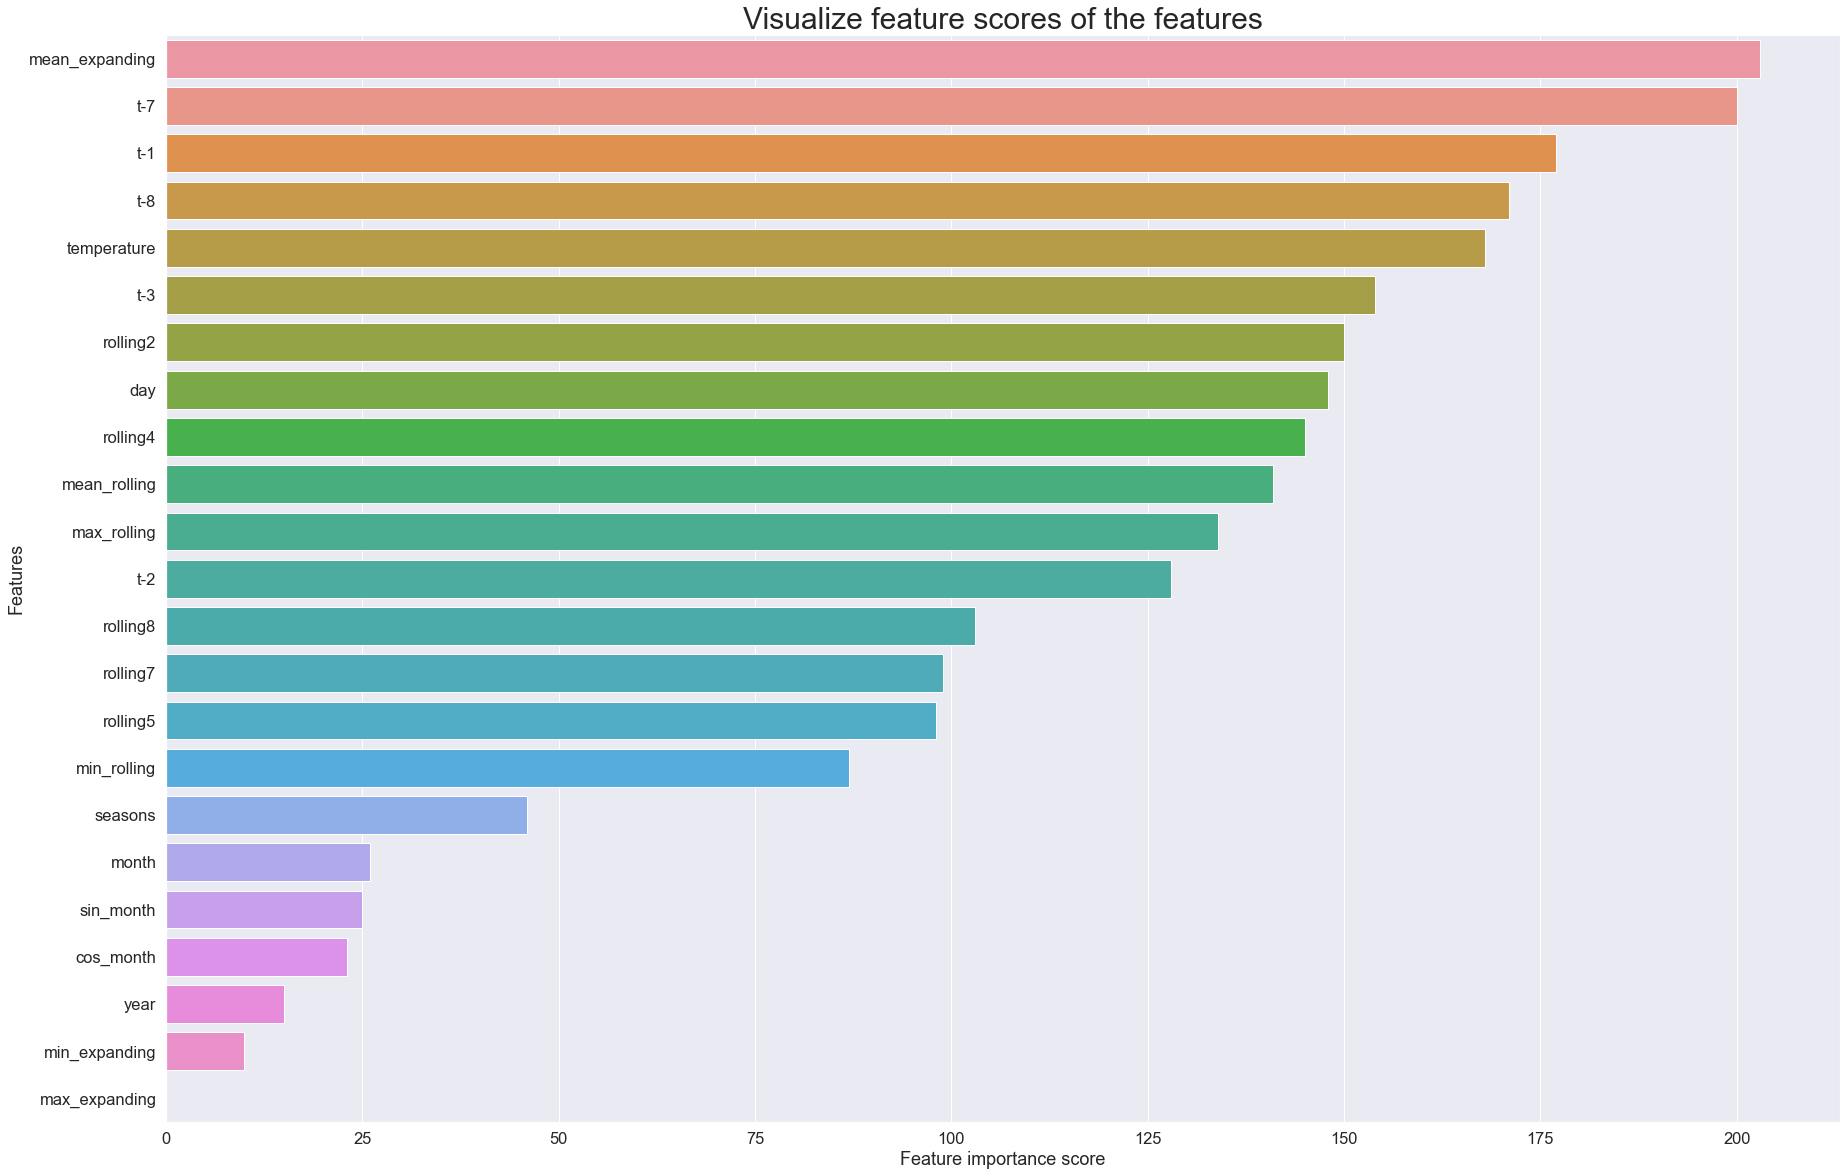

In [165]:
feature_scores = pd.Series(LGBmodel.feature_importances_, index=x_train.columns).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(30, 20))
sns.set(font_scale = 2.5)

ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)

ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
sns.set(font_scale = 3)

plt.show()

In [170]:
#GRID SEARCH FOR LIGTHGBM
parameters=[{'learning_rate': [0.001,0.005, 0.1, 0.2],
    'num_leaves': [2,5,10],
    'n_estimators': [50,100,200],
    
    'min_data': [10,15,20,25],
    'max_depth': [5, 10,15,20,25]}]
grid = GridSearchCV(estimator=LGBmodel, param_grid=parameters, scoring='neg_mean_squared_error',
                    cv=4, verbose=1)
grid.fit(x_train, y_train)


Fitting 4 folds for each of 720 candidates, totalling 2880 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be over

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=15. Current value: min_data_in_leaf=15
[Light

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=25. Current value: min_data_in_leaf=25
[Light

KeyboardInterrupt: 

In [234]:
grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_data': 10,
 'n_estimators': 100,
 'num_leaves': 5}

In [236]:

LGBmodel_tuned = lgb.LGBMRegressor(boosting_type='gbdt',learning_rate =0.1,
 max_depth= 5,
 min_data= 10,
 n_estimators= 100,
 num_leaves= 5)
clf_new = LGBmodel_tuned.fit(x_train.astype(float), y_train.astype(float))
LGBpred_tuned = LGBmodel_tuned.predict(x_test.astype(float))
evaluatereg(y_test, LGBpred_tuned)
#LGBmodel_tuned.score(x_test.astype(float),y_test.astype(float))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10


('MSE = ',
 1.1682604786903967,
 'RMSE = ',
 1.0808609895312147,
 'R2 score =',
 0.9920868894075895,
 'MAPE =',
 1.5384911605447111)

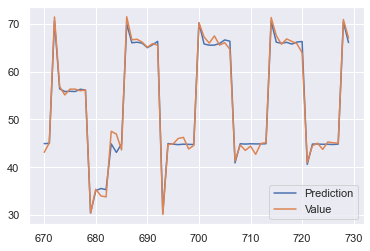

In [237]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=[12,8])
plt.plot(np.arange(670,730),LGBpred_tuned)
plt.plot(y_test)
plt.legend(['Prediction','Value'])

plt.title('XGBoost Results')
plt.xlabel('date')
plt.ylabel('Value')